In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [ ]:
df = pd.read_csv("data/USvideos.csv", encoding="latin-1")  
print("Shape:", df.shape)
df.head()

Shape: (40949, 16)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO â¶ \n\nSUBSCRIBE âº ...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [3]:
print("Columns:\n", df.columns)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Columns:
 Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

Data types:
 video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object

Missing values:
 video_id                    0
trending_date               0
title                       0
channel_title               0
cate

In [ ]:
df['publish_time'] = pd.to_datetime(df['publish_time'], utc=True, errors='coerce').dt.tz_localize(None)
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')

df = df.dropna(subset=['publish_time', 'trending_date'])

df = df.sort_values('trending_date').drop_duplicates(subset=['video_id'], keep='first')

df['days_to_trend'] = (df['trending_date'] - df['publish_time']).dt.days

df['target'] = df['days_to_trend'].apply(lambda x: 1 if x <= 2 else 0)

df[['video_id','publish_time','trending_date','days_to_trend','target']].head()



,video_id,publish_time,trending_date,days_to_trend,target
0,2kyS6SvSYSE,2017-11-13 17:13:01,2017-11-14,0,1
4,d380meD0W0M,2017-11-12 18:01:41,2017-11-14,1,1
5,gHZ1Qz0KiKM,2017-11-13 19:07:23,2017-11-14,0,1
6,39idVpFF7NQ,2017-11-12 05:37:17,2017-11-14,1,1
7,nc99ccSXST0,2017-11-12 21:50:37,2017-11-14,1,1


In [ ]:
df['title_len'] = df['title'].astype(str).apply(len)

df['desc_len'] = df['description'].fillna("").astype(str).apply(len)

df['tag_count'] = df['tags'].astype(str).apply(lambda x: 0 if x == '[none]' or x == '[]' else len(x.split('|')))

df[['title_len', 'desc_len', 'tag_count']].head()


,title_len,desc_len,tag_count
0,34,1410,1
4,24,636,14
5,21,1545,7
6,41,503,42
7,35,736,13


In [11]:
features = [
    'views', 'likes', 'dislikes', 'comment_count',
    'category_id', 'title_len', 'desc_len', 'tag_count'
]

ml_df = df[features + ['target']].dropna()

print("ML dataset shape:", ml_df.shape)
ml_df.head()


ML dataset shape: (6351, 9)


,views,likes,dislikes,comment_count,category_id,title_len,desc_len,tag_count,target
0,748374,57527,2966,15954,22,34,1410,1,1
4,2095731,132235,1989,17518,24,24,636,14,1
5,119180,9763,511,1434,28,21,1545,7,1
6,2103417,15993,2445,1970,24,41,503,42,1
7,817732,23663,778,3432,28,35,736,13,1


In [12]:
X = ml_df.drop('target', axis=1)
y = ml_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((5080, 8), (1271, 8))

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.8489378442171518

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.14      0.22       199
           1       0.86      0.98      0.92      1072

    accuracy                           0.85      1271
   macro avg       0.72      0.56      0.57      1271
weighted avg       0.81      0.85      0.81      1271


Confusion Matrix:
 [[  27  172]
 [  20 1052]]


In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    random_state=42
)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.8512981904012589

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.13      0.22       199
           1       0.86      0.99      0.92      1072

    accuracy                           0.85      1271
   macro avg       0.74      0.56      0.57      1271
weighted avg       0.82      0.85      0.81      1271


Confusion Matrix:
 [[  26  173]
 [  16 1056]]


In [15]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb)],
    voting='soft'
)

voting.fit(X_train, y_train)
y_pred_voting = voting.predict(X_test)

print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))
print("\nClassification Report:\n", classification_report(y_test, y_pred_voting))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_voting))


Voting Classifier Accuracy: 0.8552321007081038

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.14      0.23       199
           1       0.86      0.99      0.92      1072

    accuracy                           0.86      1271
   macro avg       0.78      0.56      0.57      1271
weighted avg       0.83      0.86      0.81      1271


Confusion Matrix:
 [[  27  172]
 [  12 1060]]


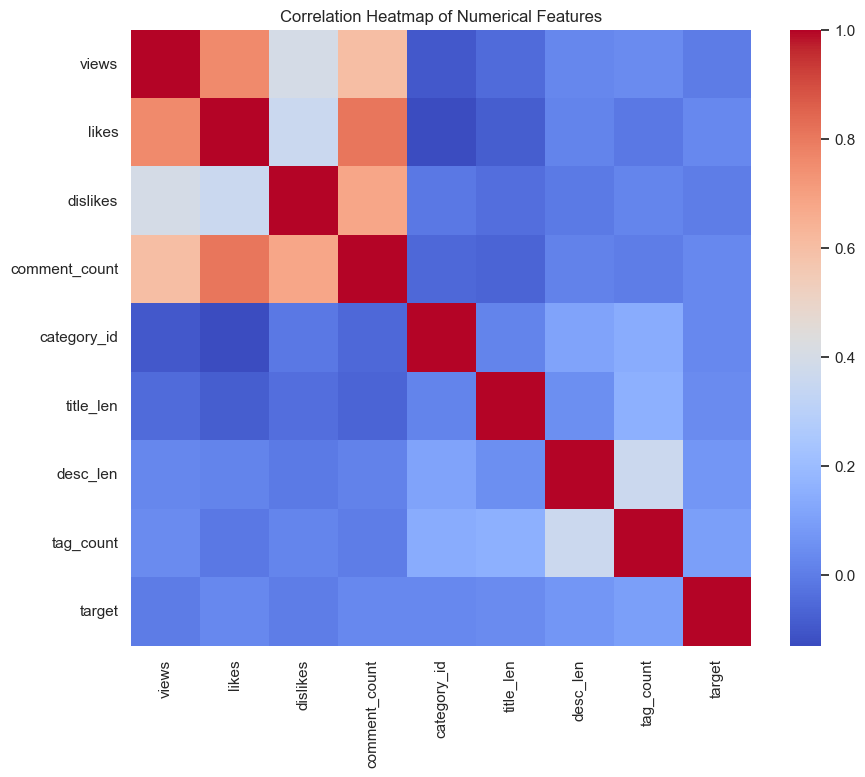

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(ml_df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Numerical Features")
plt.savefig("visuals/correlation_heatmap.png")
plt.show()


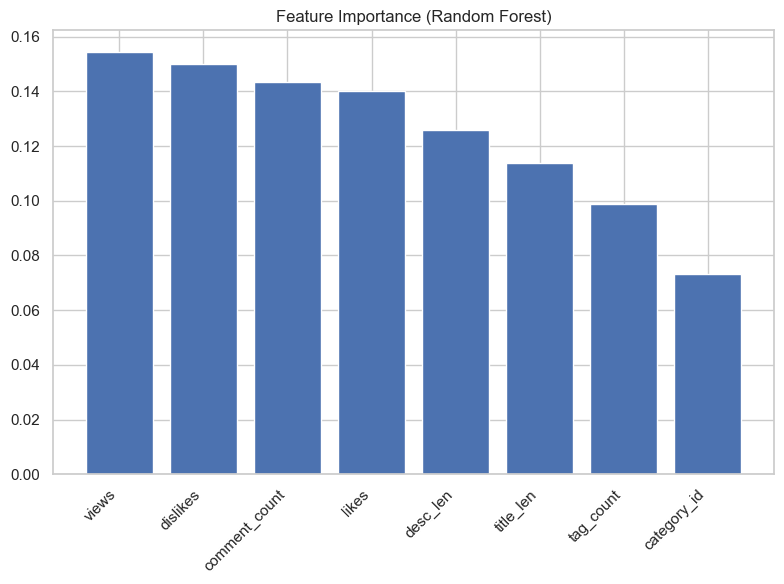

In [19]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X.columns[indices], rotation=45, ha='right')
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.savefig("visuals/feature_importance.png")
plt.show()


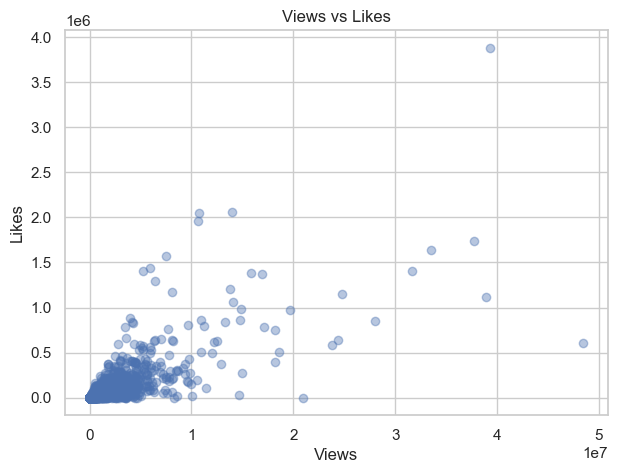

In [20]:
plt.figure(figsize=(7,5))
plt.scatter(df['views'], df['likes'], alpha=0.4)
plt.title("Views vs Likes")
plt.xlabel("Views")
plt.ylabel("Likes")
plt.savefig("visuals/views_vs_likes.png")
plt.show()


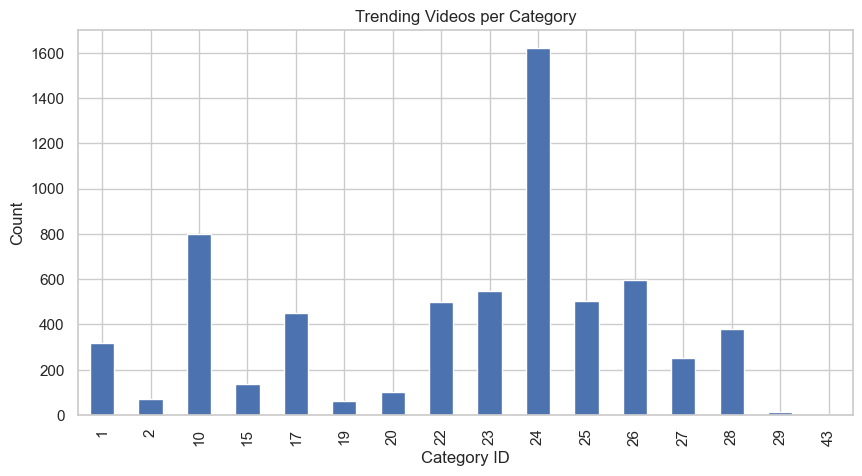

In [21]:
plt.figure(figsize=(10,5))
df['category_id'].value_counts().sort_index().plot(kind='bar')
plt.title("Trending Videos per Category")
plt.xlabel("Category ID")
plt.ylabel("Count")
plt.savefig("visuals/category_counts.png")
plt.show()
